In [ ]:
!pip install rasterio
!pip install ipdb
!pip install torchinfo
!pip install --upgrade torch torchvision
!pip install torchviz
!pip install graphviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 87.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 65.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 72.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
   

#Step 0- Utility functions and configs


In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
import rasterio as rio
import shutil
from rasterio.transform import xy
import ipdb
import random
import torch
import torch.nn as nn
import torch.optim as optim


def visualize_semantic_segmentation(img_array, class_names, class_colors, ground_truth_labels, model=None, device='gpu'):
    """
    Visualize the semantic segmentation result with ground truth and predictions.

    Args:
    - input_image_path: Path to the input image file (e.g., satellite image).
    - ground_truth_labels: Ground truth labels (if available), should be a numpy array.
    - predicted_labels: Predicted labels (if available), should be a numpy array.
    - model: Trained model used for prediction (if predicted_labels is not provided).
    - device: Device ('cpu' or 'cuda') for performing inference on the model.
    """

    # Prepare the image for prediction
    input_image = torch.tensor(img_array).unsqueeze(0).float().to(device)  # Assuming model takes input like this

    # If no predicted labels are provided, make predictions using the model
    predicted_labels = None
    if model is not None:
        model.eval()
        with torch.no_grad():
            pred = model(input_image)  # Output will be (batch_size, num_classes, height, width)
            pred = torch.argmax(pred, dim=1)  # Get the predicted class labels
        predicted_labels = pred.squeeze().cpu().numpy()

    # Create a colormap from the class colors
    colors_list = [class_colors[i] for i in range(len(class_names))]
    custom_cmap = ListedColormap(colors_list)

    # Plot the RGB image
    plt.figure(figsize=(12, 8))

    nRows = img_array.shape[1]
    ncols = img_array.shape[2]
    Bands = img_array.shape[0]
    img_array = img_array.reshape(Bands, nRows * ncols).T
    img_array = img_array.reshape(nRows, ncols, Bands)
    plt.imshow(img_array[:, :, 0:3] / 255)  # Assuming the first three bands are RGB

    plt.title('Input Image', fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    # Plot the ground truth label band (if available)
    if ground_truth_labels is not None:
        plt.figure(figsize=(12, 8))
        plt.imshow(ground_truth_labels, cmap=custom_cmap, vmin=0, vmax=5)
        plt.title('Ground Truth Labels (Land Cover Classification)', fontsize=14)

        # Add legend for ground truth
        legend_patches = [mpatches.Patch(color=class_colors[val], label=name) for val, name in class_names.items()]
        plt.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
        plt.axis('off')
        plt.tight_layout()
        plt.show()

    # Plot the predicted label map
    if model is not None:
        plt.figure(figsize=(12, 8))
        plt.imshow(predicted_labels, cmap=custom_cmap, vmin=0, vmax=5)
        plt.title('Predicted Land Cover Classes', fontsize=14)

        # Add legend for prediction map (without color bar)
        plt.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
        plt.axis('off')
        plt.tight_layout()
        plt.show()



os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ['TORCH_USE_CUDA_DSA'] = '1'

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu'))
print(f'Using device: {device}')

if device.type == 'cuda':
    batch_size = 150
else:
    batch_size = 150

# Set random seed for reproducibility
def set_seed(seed=2024):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

set_seed(2024)

cnn_model_name = 'cnn_model'
encoder_decoder_model_name='encoder_decoder_model'

from sklearn.model_selection import KFold
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import KFold
import  json
patience = 5  # For early stopping
num_epochs = 20

def mean_iou(preds, targets):
    num_classes = preds.shape[1]  # Get number of classes from channels
    preds = torch.argmax(preds, dim=1)  # Convert logits to class indices
    ious = []

    for c in range(num_classes):
        pred_c = (preds == c).float()
        target_c = (targets == c).float()

        intersection = (pred_c * target_c).sum()
        union = pred_c.sum() + target_c.sum() - intersection
        iou = (intersection + 1e-6) / (union + 1e-6)  # Smooth to avoid division by zero
        ious.append(iou)

    return sum(ious) / num_classes  # Mean IoU

def save_results(results, results_path):
    with open(results_path, 'w') as f:
        json.dump(results, f, indent=4)

def load_results(results_path):
    if os.path.exists(results_path):
        with open(results_path, 'r') as f:
            return json.load(f)
    return None

# A utility function to reset model weights
def reset_weights(m):
    if isinstance(m, torch.nn.Conv2d) or isinstance(m, torch.nn.Linear):
        m.reset_parameters()

def plot_results(results):
    plt.figure(figsize=(15, 10))

    if 'folds' in results and results['folds']:
        # K-Fold case
        plt.subplot(3, 1, 1)
        for fold in results['folds']:
            plt.plot(results['folds'][fold]['train_acc'], label=f'Fold {fold}')
        plt.title('Training Accuracy per Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.subplot(3, 1, 2)
        for fold in results['folds']:
            plt.plot(results['folds'][fold]['train_loss'], label=f'Fold {fold}')
        plt.title('Training Loss per Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(3, 1, 3)
        for fold in results['folds']:
            plt.plot(results['folds'][fold]['val_acc'], label=f'Fold {fold}')
        plt.title('Validation Accuracy per Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
    else:
        # Single train-validation case
        plt.subplot(3, 1, 1)
        plt.plot(results.get('train_acc', []), label='Training Accuracy')
        plt.title('Training Accuracy per Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.subplot(3, 1, 2)
        plt.plot(results.get('train_loss', []), label='Training Loss')
        plt.title('Training Loss per Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(3, 1, 3)
        plt.plot(results.get('val_acc', []), label='Validation Accuracy')
        plt.title('Validation Accuracy per Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

    plt.tight_layout()
    plt.show()

import os
import torch
from torch.utils.data import DataLoader, Subset, random_split
from sklearn.model_selection import KFold

def train_model(model, model_dir, model_name, train_dataset, criterion, optimizer,
                device, num_epochs, patience, batch_size, k=None, val_ratio=0.2, verbose=True, accuracy_fn=mean_iou,
                load_results=False, val_dataset=None):
    # Create model directory
    model_dir = os.path.join(model_dir, model_name)
    os.makedirs(model_dir, exist_ok=True)

    save_path = os.path.join(model_dir, f"{model_name}_best.pt")
    results_path = os.path.join(model_dir, "results.json")

    # Load previous results if available
    previous_results = None

    if load_results:
        previous_results = load_results(results_path)

    results = previous_results if previous_results else {
        'train_acc': [],
        'train_loss': [],
        'val_acc': [],
        'best_val_acc': 0.0,
        'completed_epochs': 0
    }

    if k:  # K-Fold Cross-Validation
        kf = KFold(n_splits=k, shuffle=True)
        for fold, (train_idx, val_idx) in enumerate(kf.split(train_dataset), start=1):
            print(f"Fold {fold}/{k}")
            train_subset = Subset(train_dataset, train_idx)
            val_subset = Subset(train_dataset, val_idx)
            train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

            model.apply(reset_weights)
            best_val_acc = results['best_val_acc']
            epochs_no_improve = 0  # Early stopping counter

            for epoch in range(num_epochs):
                train_one_epoch(model, train_loader, criterion, optimizer, device, epoch, num_epochs, results, verbose, accuracy_fn)
                val_acc = validate(model, val_loader, device, accuracy_fn)
                results['val_acc'].append(val_acc)
                results['completed_epochs'] = epoch + 1

                if val_acc > best_val_acc:
                    best_val_acc = val_acc
                    results['best_val_acc'] = best_val_acc
                    torch.save(model.state_dict(), save_path)
                    if verbose:
                        print(f'New best model saved with Val Acc: {best_val_acc:.2f}%')
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1
                    if epochs_no_improve >= patience:
                        print("Early stopping triggered!")
                        break

                save_results(results, results_path)
    else:  # Train-Validation Split
        if val_dataset is None:
            train_size = int((1 - val_ratio) * len(train_dataset))
            val_size = len(train_dataset) - train_size
            train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])
        else:
            train_dataset = train_dataset  # Use full dataset as training when val_dataset is predefined

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        model.apply(reset_weights)
        best_val_acc = results['best_val_acc']
        epochs_no_improve = 0  # Early stopping counter

        for epoch in range(num_epochs):
            train_one_epoch(model, train_loader, criterion, optimizer, device, epoch, num_epochs, results, verbose, accuracy_fn)
            val_acc = validate(model, val_loader, device, accuracy_fn)
            results['val_acc'].append(val_acc)
            results['completed_epochs'] = epoch + 1

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                results['best_val_acc'] = best_val_acc
                torch.save(model.state_dict(), save_path)
                if verbose:
                    print(f'New best model saved with Val Acc: {best_val_acc:.2f}%')
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= patience:
                    print("Early stopping triggered!")
                    break

            save_results(results, results_path)
    plot_results(results)
    return results

def train_one_epoch(model, train_loader, criterion, optimizer, device, epoch, num_epochs, results, verbose, accuracy_fn):
    model.train()
    running_loss, total_train, correct_train = 0.0, 0, 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        acc = accuracy_fn(outputs, labels)
        correct_train += acc.item() * labels.size(0)
        total_train += labels.size(0)
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct_train / total_train
    results['train_acc'].append(epoch_acc)
    results['train_loss'].append(epoch_loss)
    if verbose:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%')

def validate(model, val_loader, device, accuracy_fn):
    model.eval()
    total_val, correct_val = 0, 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validation", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_acc = accuracy_fn(outputs, labels)
            correct_val += val_acc.item() * labels.size(0)
            total_val += labels.size(0)
    return 100 * correct_val / total_val

import gc         # garbage collect library
def delete_model(model):
  del model  #deleting the model
  # model will still be on cache until its place is taken by other objects so also execute the below lines
  gc.collect()
  torch.cuda.empty_cache()

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()

import torch.nn as nn

# Default join operation (concatenation)
def concat(x, skip):
    return torch.cat([x, skip], dim=1)  # Concatenation along channel dimension


class EncoderDecoder(nn.Module):
    def __init__(self, input_shape, output_shape, filter_sizes, pool_stride=2, kernel_size=3, conv_factor=1, pool_size=2, decode=False,
                 conv_layer=nn.Conv2d, pool_layer=nn.MaxPool2d, activation_layer=nn.ReLU,
                 upsample_layer=nn.ConvTranspose2d, padding_mode='zeros', padding=1, join_operation=concat,interpolate_mode='bilinear'):

        super(EncoderDecoder, self).__init__()

        self.encoder_blocks = nn.ModuleList()
        self.decoder_blocks = nn.ModuleList()
        self.head_block = nn.ModuleList()
        self.hook_handles = []
        self.output_shapes = []
        self.decode = decode
        self.join_operation = join_operation
        self.output_shape = output_shape
        self.interpolate_mode=interpolate_mode

        def hook_fn(module, input, output):
            self.output_shapes.append(output.shape)

        # Encoder
        output_shape = input_shape
        for i in range(len(filter_sizes)):
            for j in range(conv_factor):
                if i == 0 and j == 0:
                    conv_block = nn.Sequential(
                        conv_layer(input_shape[1], filter_sizes[i], kernel_size=kernel_size,
                                   padding=padding, padding_mode=padding_mode),
                        activation_layer()
                    )
                else:
                    conv_block = nn.Sequential(
                        conv_layer(output_shape[1], filter_sizes[i], kernel_size=kernel_size,
                                   padding=padding, padding_mode=padding_mode),
                        activation_layer()
                    )
                conv_block.add_module(str(len(conv_block)), pool_layer(kernel_size=pool_size, stride=pool_stride))
                self.encoder_blocks.append(conv_block)
                output_shape = (output_shape[0], filter_sizes[i], output_shape[2], output_shape[3])

        # Decoder
        if self.decode:
            in_channels_list = self._detect_decoder_input_channels(filter_sizes)
            out_channels_list = filter_sizes[:-1][::-1] + [filter_sizes[0]]

            for i in range(len(in_channels_list)):
                deconv_block = nn.Sequential(
                    upsample_layer(in_channels_list[i], out_channels_list[i], kernel_size=kernel_size, stride=pool_stride, padding=padding, output_padding=1),
                    activation_layer()
                )
                self.decoder_blocks.append(deconv_block)

            self.head_block = nn.Sequential(
                conv_layer(out_channels_list[-1], self.output_shape[1], kernel_size=kernel_size,
                           padding=padding, padding_mode=padding_mode)
            )

        # Register hooks
        for block in [*self.encoder_blocks, *self.decoder_blocks]:
            for layer in block.children():
                self.hook_handles.append(layer.register_forward_hook(hook_fn))

        # Apply weight initialization
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def unhook(self):
        for hook in self.hook_handles:
            hook.remove()

    def _detect_decoder_input_channels(self, filter_sizes):
        detected_channels = []
        skip_channels_list = filter_sizes[:-1][::-1]
        for skip_channels in skip_channels_list:
            dummy_x = torch.randn(1, skip_channels, 8, 8)
            dummy_skip = torch.randn(1, skip_channels, 8, 8)
            joined = self.join_operation(dummy_x, dummy_skip) if self.join_operation else dummy_x
            detected_channels.append(joined.shape[1])
        return [filter_sizes[-1]] + detected_channels

    def forward(self, x, plot_architecture=False):
        # Clear previous output shapes
        self.output_shapes = []

        if plot_architecture:
            try:
                from graphviz import Digraph
                from IPython.display import Image, display
                visualize = True
                dot = Digraph('EncoderDecoder_Architecture', format='png',
                             graph_attr={'rankdir': 'LR', 'splines': 'ortho'},
                             node_attr={'shape': 'rect', 'style': 'filled', 'fillcolor': 'lightblue', 'width': '2.0'})

                # Track shapes and connections
                node_counter = 0

                # Input node
                input_shape = tuple(x.shape[1:])
                dot.node(f"node_{node_counter}", f"Input\n{input_shape}", shape="ellipse", fillcolor="white")
                prev_node = f"node_{node_counter}"
                node_counter += 1
                encoder_nodes = []
            except ImportError:
                print("Graphviz/IPython not available - skipping visualization")
                visualize = False
        else:
            visualize = False

        enc_outputs = []
        for block in self.encoder_blocks:
            if visualize:
                block_input_shape = tuple(x.shape[1:])

            x = block(x)
            enc_outputs.append(x)

            if visualize:
                block_output_shape = tuple(x.shape[1:])
                label = []
                for layer in block:
                    if isinstance(layer, nn.Conv2d):
                        label.append(f"Conv2D\nFilters={layer.out_channels}\nKernel={layer.kernel_size}")
                    elif isinstance(layer, nn.MaxPool2d):
                        label.append(f"MaxPool2D\nKernel={layer.kernel_size}\nStride={layer.stride}")
                    elif isinstance(layer, nn.ReLU):
                        label.append("ReLU")
                    elif isinstance(layer, nn.Identity):
                        label.append("Identity")

                dot.node(f"node_{node_counter}", "\n".join(label) + f"\nOutput: {block_output_shape}")
                dot.edge(prev_node, f"node_{node_counter}")
                encoder_nodes.append((f"node_{node_counter}", block_output_shape))
                prev_node = f"node_{node_counter}"
                node_counter += 1

        if self.decode:
            for i, block in enumerate(self.decoder_blocks):
                if visualize:
                    block_input_shape = tuple(x.shape[1:])

                x = block(x)

                if visualize:
                    block_output_shape = tuple(x.shape[1:])
                    label = []
                    for layer in block:
                        if isinstance(layer, nn.ConvTranspose2d):
                            label.append(f"ConvTranspose2D\nFilters={layer.out_channels}\nKernel={layer.kernel_size}")
                        elif isinstance(layer, nn.ReLU):
                            label.append("ReLU")

                    dot.node(f"node_{node_counter}", "\n".join(label) + f"\nOutput: {block_output_shape}")
                    dot.edge(prev_node, f"node_{node_counter}")

                    # Add skip connection if exists
                    skip_idx = -(i + 2)
                    if abs(skip_idx) <= len(encoder_nodes):
                        skip_node, skip_shape = encoder_nodes[skip_idx]

                        if self.join_operation:
                            # Add join operation node
                            join_node = f"node_{node_counter}_join"
                            join_label = f"Join\nOperation: {self.join_operation.__name__}\nChannels: {x.shape[1]}+{skip_shape[0]}"
                            dot.node(join_node, join_label, fillcolor="lightgreen")

                            # Connect both paths to join node
                            dot.edge(f"node_{node_counter}", join_node)
                            dot.edge(skip_node, join_node, style="dashed", color="gray")

                            # Update prev_node to the join node
                            prev_node = join_node
                            node_counter += 1
                        else:
                            dot.edge(skip_node, f"node_{node_counter}", style="dashed", color="gray", label=f"Skip\n{skip_shape}")

                    prev_node = f"node_{node_counter}"
                    node_counter += 1

                # Handle actual skip connections in computation
                if i < len(enc_outputs) - 1:
                    skip = enc_outputs[-(i + 2)]
                    if x.shape[2:] != skip.shape[2:]:
                        x = nn.functional.interpolate(x, size=skip.shape[2:], mode=self.interpolate_mode, align_corners=True)
                    x = self.join_operation(x, skip) if self.join_operation else x

                    # Ensure prev_node is updated after joining
                    if visualize:
                        prev_node = join_node  # This ensures that the next layer is linked correctly in visualization

        for block in self.head_block:
            if visualize:
                block_input_shape = tuple(x.shape[1:])

            x = block(x)

            if visualize:
                block_output_shape = tuple(x.shape[1:])
                if isinstance(block, nn.Conv2d):
                    label = f"Final Conv2D\nFilters={block.out_channels}\nKernel={block.kernel_size}"
                else:
                    label = "Head Layer"

                dot.node(f"node_{node_counter}", f"{label}\nOutput: {block_output_shape}")
                dot.edge(prev_node, f"node_{node_counter}")
                prev_node = f"node_{node_counter}"
                node_counter += 1

        if x.shape[2:] != self.output_shape[2:]:
            x = nn.functional.interpolate(x, size=self.output_shape[2:], mode=self.interpolate_mode, align_corners=False)

        if visualize:
            # Output node
            output_shape = tuple(x.shape[1:])
            dot.node(f"node_{node_counter}", f"Output\n{output_shape}", shape="ellipse", fillcolor="white")
            dot.edge(prev_node, f"node_{node_counter}")

            # Render and display
            dot.render('model_architecture', cleanup=True)
            display(Image(filename='model_architecture.png'))

        return x.squeeze(1) if x.shape[1] == 1 else x


    # Define the class names and their corresponding colors
class_names = {
    0: "Impervious surface",
    1: "Building",
    2: "Tree",
    3: "Low vegetation",
    4: "Car",
    5: "Clutter/Background"
}

def evaluate_model(model, test_loader, device, verbose=True, accuracy_fn=mean_iou):
    """
    Evaluate the model on the test dataset.

    Args:
        model (torch.nn.Module): The trained model to evaluate.
        test_loader (torch.utils.data.DataLoader): DataLoader for the test dataset.
        device (torch.device): Device to run the evaluation on (e.g., 'cuda' or 'cpu').
        verbose (bool): If True, print evaluation results.
        accuracy_fn (function): Function to compute accuracy (default is mean_iou).

    Returns:
        dict: A dictionary containing evaluation results.
    """
    model.eval()  # Set the model to evaluation mode
    total_test, correct_test = 0, 0
    test_results = {'test_acc': 0.0}

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            test_acc = accuracy_fn(outputs, labels)
            correct_test += test_acc.item() * labels.size(0)
            total_test += labels.size(0)

    test_acc = 100 * correct_test / total_test
    test_results['test_acc'] = test_acc

    if verbose:
        print(f'Test Accuracy: {test_acc:.2f}%')

    return test_results


def load_best_model(model, model_dir, model_name, device):
    """
    Loads the best saved model checkpoint from the specified directory.

    Args:
        model (torch.nn.Module): The model architecture.
        model_dir (str): Directory where the model is saved.
        model_name (str): Name of the model.
        device (torch.device): Device to load the model on (e.g., 'cpu' or 'cuda').

    Returns:
        torch.nn.Module: The model with loaded weights.
    """
    model_path = os.path.join(model_dir, model_name, f"{model_name}_best.pt")
    if os.path.exists(model_path):
        model.load_state_dict(torch.load(model_path, map_location=device))
        # This is the important change to transfer the model to the correct device
        model.to(device)
        model.eval()
        print(f"Loaded best model from {model_path}")
    else:
        print(f"No best model found at {model_path}. Returning initialized model.")

    return model

# Create a color map with distinct colors for each class
class_colors = {
    0: (0.7, 0.7, 0.7),    # Gray for impervious surface
    1: (0.9, 0.0, 0.0),    # Red for building
    2: (0.0, 0.8, 0.0),    # Green for tree
    3: (0.0, 0.6, 0.3),    # Light green for low vegetation
    4: (0.0, 0.0, 1.0),    # Blue for car
    5: (1.0, 1.0, 0.0)     # Yellow for clutter/background
}

Using device: cpu


#Step 1- Dataset preparation:


In [ ]:

# Create a folder to extract the files
import os

extract_path = "/content/extracted_files"
PathToGeoTiffFile = os.path.join(extract_path, 'Potsdam-GeoTif')


file_id = "1ODRghvcRWp9WabC34dh11Cd0iHw0bamJ"
output_file = "downloaded_file.zip"

!gdown --id $file_id -O $output_file

print(f"File {output_file} downloaded successfully!")

os.makedirs(extract_path, exist_ok=True)

# Extract the zip file
!unzip -q "$output_file" -d "$extract_path"

print(f"File extracted to {extract_path}")


/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1ODRghvcRWp9WabC34dh11Cd0iHw0bamJ
From (redirected): https://drive.google.com/uc?id=1ODRghvcRWp9WabC34dh11Cd0iHw0bamJ&confirm=t&uuid=e02576be-6423-43ef-8db2-2ec7e98f61b3
To: /content/downloaded_file.zip
100% 4.93G/4.93G [01:07<00:00, 72.8MB/s]
File downloaded_file.zip downloaded successfully!
File extracted to /content/extracted_files


In [ ]:
def extract_xy_from_geotiff(filename, image_dir):
    """Extracts (x, y) coordinates from GeoTIFF files based on the center pixel."""
    # Get the full path of the image
    image_path = os.path.join(image_dir, filename)
    with rio.open(image_path) as dataset:
        width, height = dataset.width, dataset.height
        # Calculate the center pixel coordinates
        center_x = width // 2
        center_y = height // 2
        # Convert pixel coordinates to geospatial coordinates (lon, lat)
        lon, lat = xy(dataset.transform, center_y, center_x)
        return lon, lat

def create_sorted_grid_map(image_dir):
    """
    Sorts images into a grid-like structure based on their longitude and latitude (center coordinates).

    Args:
        image_dir (str): Directory containing images.

    Returns:
        list: List of (filename, lon, lat) with sorted coordinates.
    """
    image_files = os.listdir(image_dir)
    image_files = [f for f in image_files if f.endswith('.tif')]
    images = [(f, extract_xy_from_geotiff(f, image_dir)) for f in image_files]

    # Remove invalid filenames (if any extraction fails)
    images = [(f, coords) for f, coords in images if coords is not None]

    # Sort by longitude first, then by latitude
    images.sort(key=lambda item: (item[1][0], item[1][1]))  # Sorting by lon, then lat

    # Assign new grid coordinates
    grid_map = []
    grid_x, grid_y = 0, 0
    last_x = None
    for filename, (x, y) in images:
        if last_x is None or x != last_x:
            grid_x += 1  # Move to next row in the grid
            grid_y = 0  # Reset column index
        grid_map.append((filename, grid_x, grid_y))
        grid_y += 1
        last_x = x

    return grid_map

import os
import shutil

def split_checkerboard_with_ratio(
    image_dir,
    train_ratio=None,
    train_folder="train",
    test_folder="test",
    square_size=1
):
    """
    Moves files into train/test folders using a checkerboard pattern,
    while ensuring the ratio of train/test matches the specified `train_ratio`.

    Args:
        image_dir (str): Source directory of images.
        train_ratio (float): Desired ratio of training data (default: 0.8).
        train_folder (str): Directory to move training images.
        test_folder (str): Directory to move testing images.
        square_size (int): Width of each checkerboard square.
    """
    os.makedirs(image_dir, exist_ok=True)
    train_dir = os.path.join(image_dir, train_folder)
    test_dir = os.path.join(image_dir, test_folder)

    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    # If image_dir is empty but train and test directories exist, move all images back
    if not any(f.endswith(".tif") for f in os.listdir(image_dir)) and (
        any(f.endswith(".tif") for f in os.listdir(train_dir)) or any(f.endswith(".tif") for f in os.listdir(test_dir))
    ):
        print("Moving images from train/test folders back to image directory...")
        for folder in [train_dir, test_dir]:
            for filename in os.listdir(folder):
                file_path = os.path.join(folder, filename)
                if os.path.isfile(file_path) and filename.endswith(".tif"):
                    shutil.move(file_path, os.path.join(image_dir, filename))
        print("Retrying split after restoring images...")

    # Get sorted grid mapping (based on longitude and latitude)
    print("Creating sorted grid map using directory: ", image_dir)
    grid_map = create_sorted_grid_map(image_dir)
    total_images = len(grid_map)
    print(f"Grid map created with {total_images} images.")

    # Apply checkerboard pattern
    train_files = []
    test_files = []

    for filename, grid_x, grid_y in grid_map:
      if filename.endswith((".tif")):
        # Apply checkerboard pattern
        is_train = ((grid_x // square_size) + (grid_y // square_size)) % 2 == 0
        if is_train:
            train_files.append(filename)
        else:
            test_files.append(filename)

    # Adjust to meet the desired ratio
    if train_ratio:
        desired_train_count = int(train_ratio * total_images)
        print("desired_train_count: ", desired_train_count)
        current_train_count = len(train_files)

        if current_train_count < desired_train_count:
            num_to_move = min(desired_train_count - current_train_count, len(test_files))
            train_files.extend(test_files[:num_to_move])
            test_files = test_files[num_to_move:]
        elif current_train_count > desired_train_count:
            num_to_move = min(current_train_count - desired_train_count, len(train_files))
            test_files.extend(train_files[-num_to_move:])
            train_files = train_files[:-num_to_move]

    # Move files to their respective folders
    for filename in train_files:
        if filename.endswith(".tif"):
            try:
                shutil.move(os.path.join(image_dir, filename), os.path.join(train_dir, filename))
            except Exception as e:
                print(f"Skipping {filename} (error: {e})")

    for filename in test_files:
        if filename.endswith(".tif"):
            try:
                shutil.move(os.path.join(image_dir, filename), os.path.join(test_dir, filename))
            except Exception as e:
                print(f"Skipping {filename} (error: {e})")

    print(
        f"Data split complete! Train images: {len(os.listdir(train_dir))}, "
        f"Test images: {len(os.listdir(test_dir))}"
    )


# Example usage:
split_checkerboard_with_ratio(
    image_dir=PathToGeoTiffFile,
    train_ratio=0.6,
    square_size=1     # Checkerboard square width
)


Creating sorted grid map using directory:  /content/extracted_files/Potsdam-GeoTif
Grid map created with 15048 images.
desired_train_count:  9028
Data split complete! Train images: 9028, Test images: 6020


In [ ]:

# Create a folder to extract the files

extract_path = "/content/extracted_files"
PathToGeoTiffFile = os.path.join(extract_path, 'Potsdam-GeoTif')

train_data_dir = os.path.join(PathToGeoTiffFile, 'train')
test_data_dir = os.path.join(PathToGeoTiffFile, 'test')
default_image = os.path.join(train_data_dir,os.listdir(train_data_dir)[2])



from torch.utils.data import Dataset
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,random_split

class GeoTiffDataset(Dataset):
    def __init__(self, image_dir, default_image, transform=None, sample_size=None):

        self.default_image=default_image
        # Collect all image paths
        self.image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.tif')]

        # If sample_size is provided, randomly select that many samples
        if sample_size:
            self.image_paths = random.sample(self.image_paths, min(sample_size, len(self.image_paths)))

        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image=None

        try:
            with rio.open(img_path) as src:
                image = src.read()  # (Bands, Height, Width)
                src.close()

        except rio.errors.RasterioIOError as e:
            print(f"Error reading {img_path}: {e}")
            # Handle the error by returning a default image and label
            # Use zeros for both image and label or skip this entry
            with rio.open(self.default_image) as src:
                image = src.read()
                src.close()


        # Split features (X) and labels (y)
        X = image[:4, :, :]  # First 4 bands (Red, Green, Blue, IR)
        X = X.astype(np.float32) / np.max(X)
        y = image[5, :, :]  # 6th band (Segmentation mask or labels
        # Apply transformations (only to X)
        if self.transform:
            X = self.transform(X)
        # Convert X back to (C, H, W) and y to tensor
        X = torch.tensor(X)  # .permute(2, 0, 1)  # (H, W, C) → (C, H, W)
        y = torch.tensor(y, dtype=torch.long)  # Convert labels to tensor

        return X, y


# Define transformations for input images
transform = transforms.Compose([
    # Convert to tensor using Lambda
    transforms.Lambda(lambda x: torch.tensor(x)),

    # Data augmentation: Random horizontal and vertical flipping
    transforms.RandomHorizontalFlip(p=0.5),  # 50% chance of flipping horizontally
    transforms.RandomVerticalFlip(p=0.5),    # 50% chance of flipping vertically

    # Data augmentation: Random rotation (e.g., between -90 and 90 degrees)
    transforms.RandomRotation(degrees=(-90, 90)),  # Rotate randomly within the specified range

    # Normalize 4 bands
    transforms.Normalize(mean=[0.5] * 4, std=[0.5] * 4)
])

# Load Dataset
train_dataset = GeoTiffDataset(train_data_dir, default_image=default_image, transform=transform,sample_size=None)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
input_shape=None
label_shape=None

# Example: Iterate through DataLoader
for X_batch, y_batch in train_dataloader:
    input_shape=X_batch.shape
    label_shape=y_batch.shape
    print(X_batch.shape, y_batch.shape)
    labels=np.unique(y_batch)
    print("labels: ",labels)
    # Expected output: (16, 5, 224, 224) for inputs, (16, 224, 224) for labels
    break

test_dataset = GeoTiffDataset(test_data_dir, default_image=default_image, transform=transform,sample_size=None)

val_ratio=0.5
# Define the sizes for each subset (80% train, 10% val, 10% test)
val_size = int(val_ratio* len(test_dataset))
print("val_size: ",val_size)
test_size = len(test_dataset) - val_size  # Ensure total sum is 100%
print("test_size: ",test_size)

# Split the dataset into train, val, and test sets
val_dataset, test_dataset = random_split(test_dataset, [val_size, test_size])

import time
from google.colab import drive


def drive_mount():
    # Attempt to mount Google Drive
    mount_dir = '/content/drive'
    try:
        drive.mount(mount_dir, force_remount=True)
        return mount_dir + '/MyDrive/'
    except Exception as e:
        print(f"Drive mount failed: {e}. Using default directory.")
        return ''

# Path to save the model
model_dir= drive_mount()


<ipython-input-7-dc5f602e94d1>:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X)  # .permute(2, 0, 1)  # (H, W, C) → (C, H, W)


torch.Size([150, 4, 224, 224]) torch.Size([150, 224, 224])
labels:  [0 1 2 3 4 5]
val_size:  3010
test_size:  3010
Mounted at /content/drive


In [ ]:
cnn_filter_sizes = [32, 6]
encoder_decoder_filter_sizes=[32,64,64]
output_shape=(1,len(class_names),*list(label_shape[len(label_shape)-2:len(label_shape)]))
print(output_shape)


(1, 6, 224, 224)


In [ ]:
# Load Dataset
test_dataset = GeoTiffDataset(test_data_dir, default_image=default_image, transform=transform,sample_size=None)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
default_image = os.path.join(train_data_dir,os.listdir(train_data_dir)[2])
# Open and process the image
img = rio.open(default_image)
img_array = img.read()
imtransform = img.transform

# Split features (X) and labels (y)
X = img_array[:4, :, :]  # First 4 bands (Red, Green, Blue, IR)
y = img_array[5, :, :]  # 6th band (Segmentation mask or labels

#Step 2- Training a simple CNN model:



cnn_model


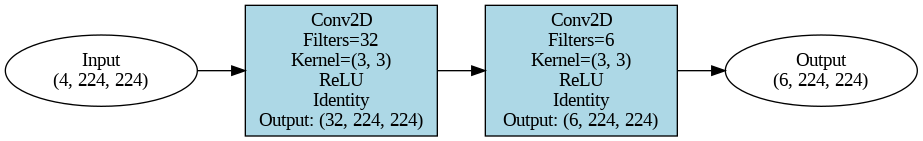

torch.Size([150, 6, 224, 224])


In [ ]:

# Create model and move to device
cnn_model = EncoderDecoder(input_shape=input_shape, output_shape=output_shape ,pool_layer=nn.Identity,filter_sizes=cnn_filter_sizes).to(device)
print("cnn_model")
cnn_output=cnn_model.forward(torch.randn(input_shape).to(device),plot_architecture=True)
print(cnn_output.shape)
cnn_model.unhook()
cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=0.01, weight_decay=0.0005)

In [ ]:
cnn_results=train_model(model=cnn_model, model_dir=model_dir, model_name=cnn_model_name, train_dataset=train_dataset,
                        val_dataset=val_dataset,
                    criterion=criterion, optimizer=cnn_optimizer,
                device=device, num_epochs=num_epochs, patience=patience, batch_size=batch_size,
                    k=None, verbose=True, accuracy_fn=mean_iou)

In [ ]:
cnn_model=load_best_model(model=EncoderDecoder(input_shape=input_shape, output_shape=output_shape ,pool_layer=nn.Identity,filter_sizes=cnn_filter_sizes)
,model_dir=model_dir,model_name=cnn_model_name,device=device)
cnn_model.unhook()

Loaded best model from /content/drive/MyDrive/cnn_model/cnn_model_best.pt


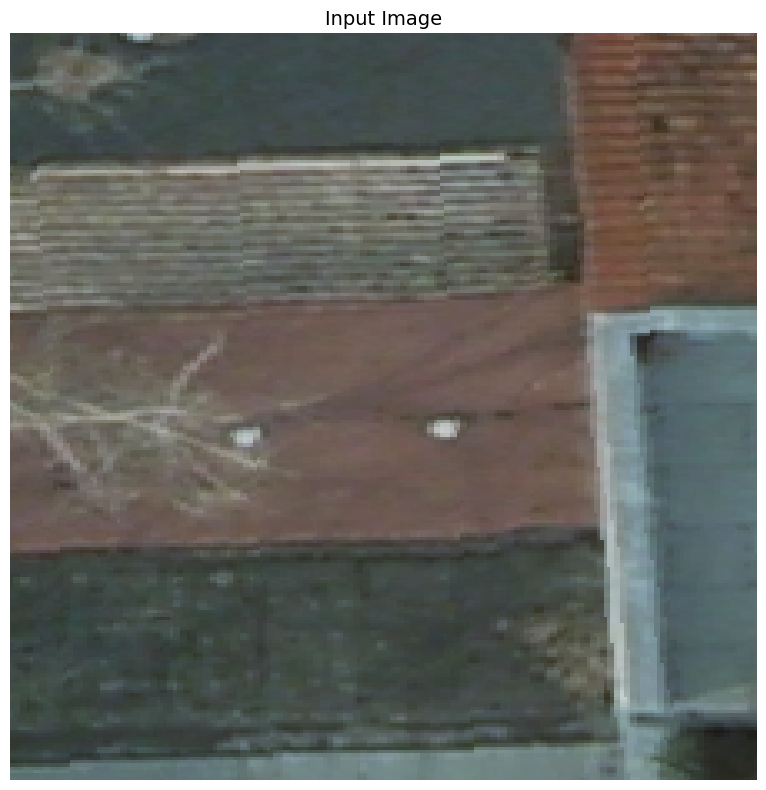

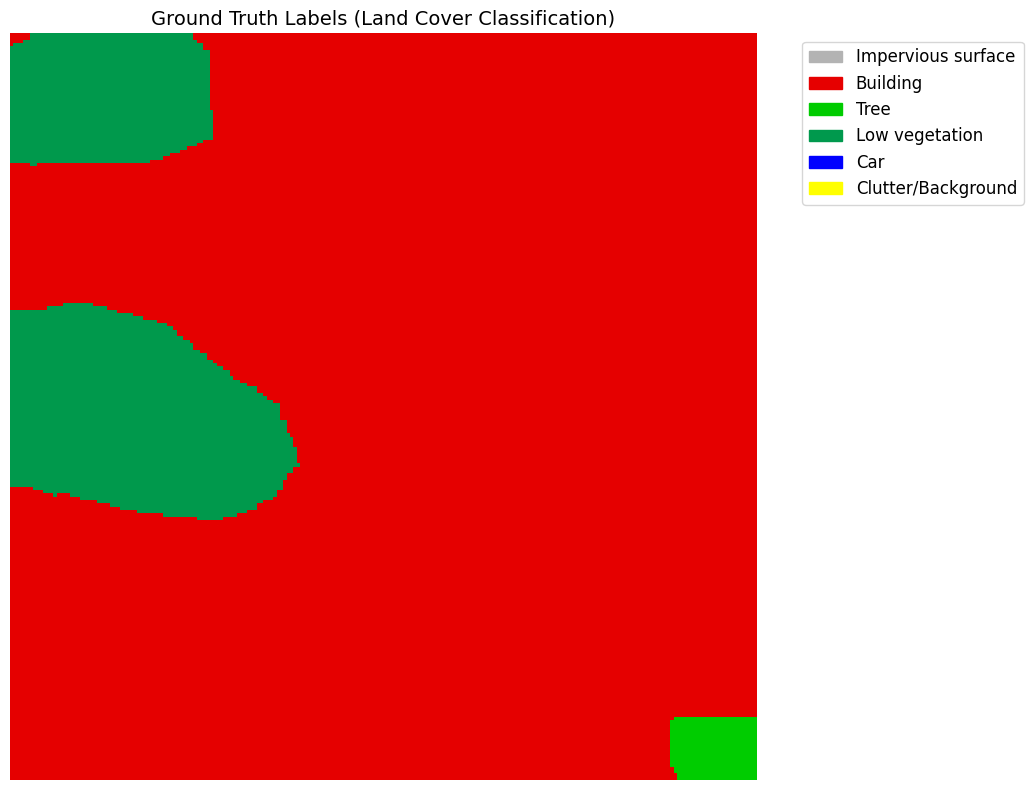

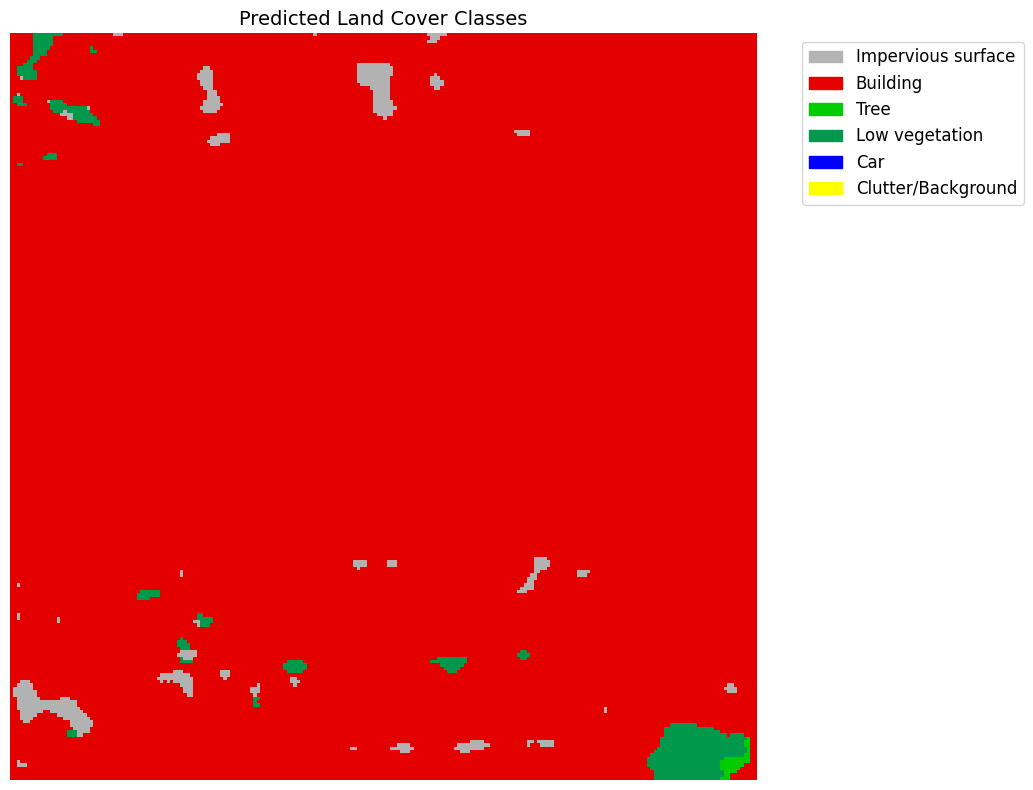

In [ ]:
visualize_semantic_segmentation(img_array=X,
                                ground_truth_labels=y,
                                class_names=class_names,
                                class_colors=class_colors,
                                model=cnn_model,  # Assuming cnn_model is your trained model
                                device=device)  # Make sure to set device to 'cpu' or 'cuda'

In [ ]:
# Final evaluation
cnn_eval = evaluate_model(
    model=cnn_model,
    test_loader=test_dataloader,
    device=device,
    verbose=True
)

#Step 3- Training an Encoder Decoder (U-net) model

encoder_decoder_model


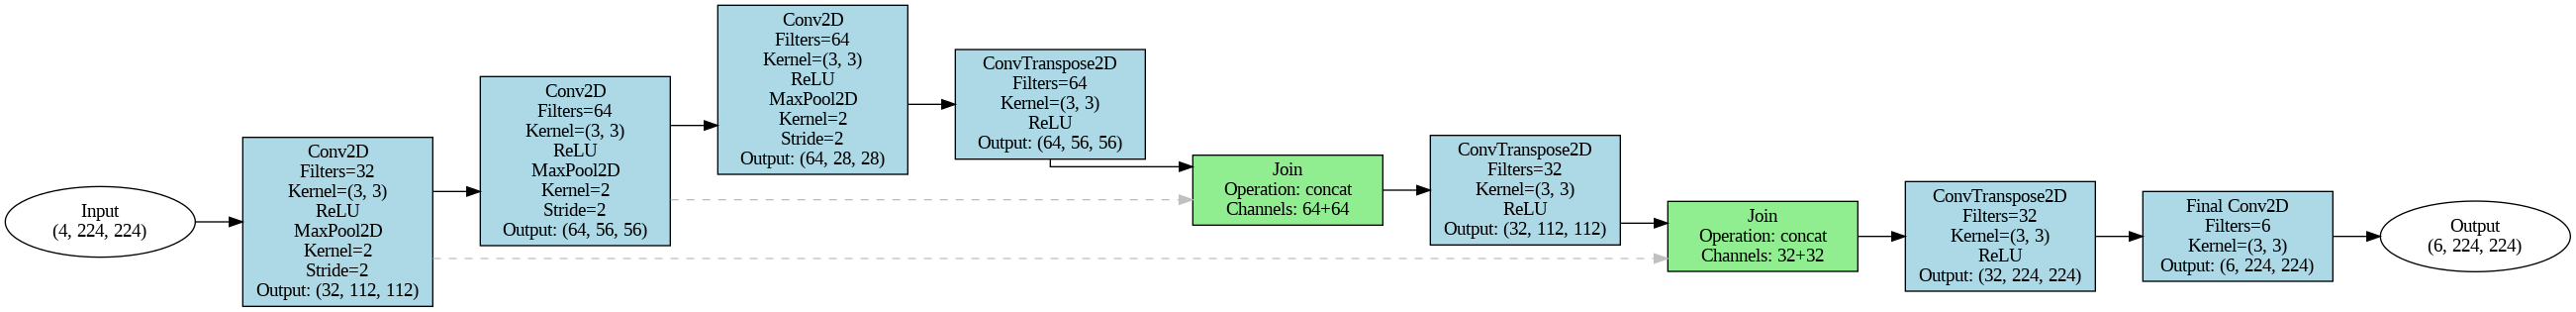

torch.Size([150, 6, 224, 224])


In [ ]:
encoder_decoder_model= EncoderDecoder(input_shape=input_shape,output_shape=output_shape,filter_sizes=encoder_decoder_filter_sizes,decode=True).to(device) # Move the model to the device

print("encoder_decoder_model")
encoder_decoder_output=encoder_decoder_model(torch.randn(input_shape).to(device),plot_architecture=True)
print(encoder_decoder_output.shape)
encoder_decoder_model.unhook()
encoder_decoder_optimizer = optim.Adam(encoder_decoder_model.parameters(), lr=0.01, weight_decay=0.0005)


In [ ]:
encoder_decoder_results=train_model(model=encoder_decoder_model, model_dir=model_dir, model_name='encoder_decoder_model', train_dataset=train_dataset,
                    val_dataset=val_dataset, criterion=criterion, optimizer=encoder_decoder_optimizer,
                device=device, num_epochs=num_epochs, patience=patience, batch_size=batch_size,
                    k=None, val_ratio=0.2, verbose=True, accuracy_fn=mean_iou)

In [ ]:
#EncoderDecoder(input_shape=input_shape,output_shape=(1, 6, 224, 224),filter_sizes=encoder_decoder_filter_sizes,decode=True).to(device)
encoder_decoder_model = load_best_model(model=EncoderDecoder(input_shape=input_shape,output_shape=output_shape,filter_sizes=encoder_decoder_filter_sizes,decode=True),
                                        model_dir=model_dir,model_name=encoder_decoder_model_name,device=device)
encoder_decoder_model.unhook()

Loaded best model from /content/drive/MyDrive/encoder_decoder_model/encoder_decoder_model_best.pt


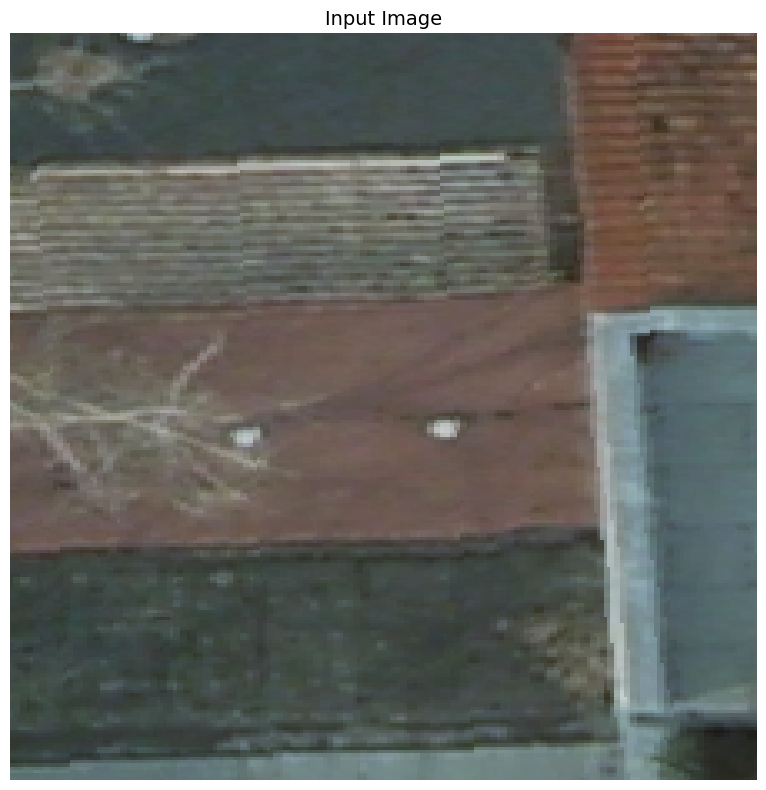

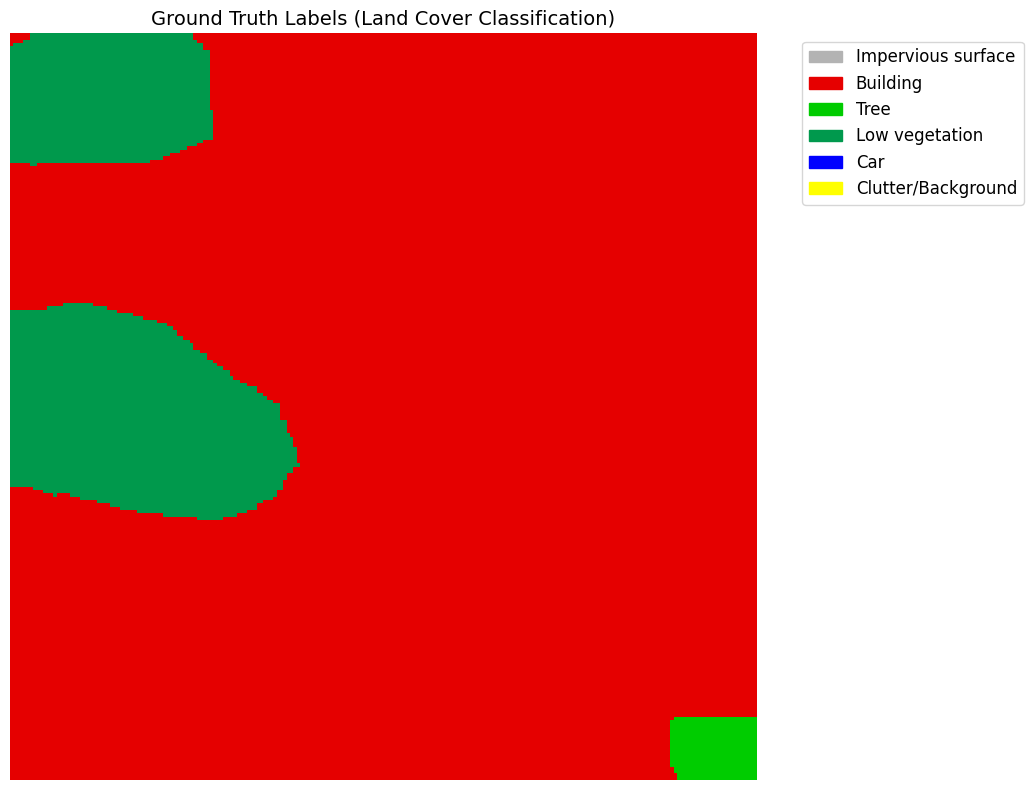

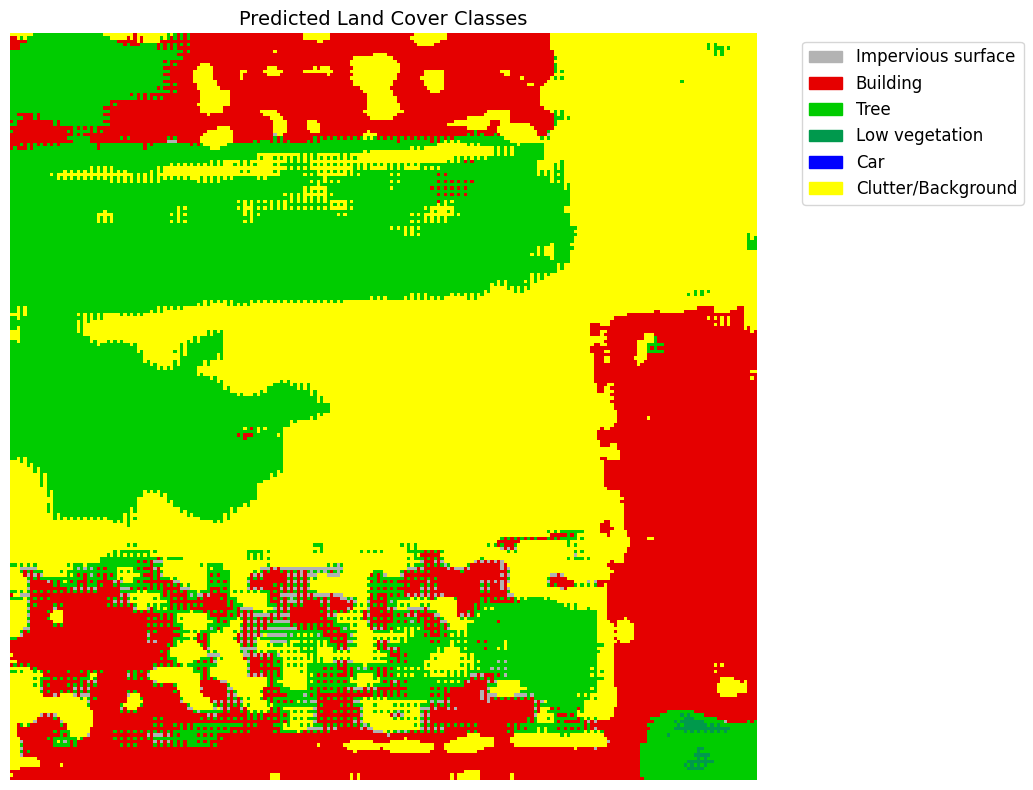

In [ ]:
visualize_semantic_segmentation(img_array=X,
                                ground_truth_labels=y,
                                class_names=class_names,
                                class_colors=class_colors,
                                model=encoder_decoder_model,  # Assuming cnn_model is your trained model
                                device=device)  # Make sure to set device to 'cpu' or 'cuda'

In [ ]:
# Final evaluation
encoder_decoder_eval = evaluate_model(
    model=encoder_decoder_model,
    test_loader=test_dataloader,
    device=device,
    verbose=True
)